In [1]:
import os
import mido
import utils ##
import random
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import torch
from torch.utils.data import DataLoader

## Importar Datos

In [3]:
df_audios = pd.read_csv('datos_procesados/valid_samples.csv', index_col=0)
audio_names = list(df_audios.index)

## Dataset

- Definición del objeto Dataset para importar los datos

In [4]:
class TarareoMIDIDataset(torch.utils.data.Dataset):
    def __init__(self, tarareo_directory: str, midi_directory: str, samples: list, extensions: tuple[str, str]):
        self._tarareo_directory = tarareo_directory
        self._midi_directory = midi_directory

        self._samples = samples #  Nombre del elemento de grabación
        self._extensions = extensions #  extension del nombre del tarareo y vector midi. Ejm audio_name[extension] (incluye formato)

        # Si usamos PADDING, será conveniente tener un vocabulario como si se tratara de una traducción en NLP
        # Esto ayuda a ordenar las etiquetas por orden de frecuencia
        # Colocando en las primeras casillas a las etiquetas de inicio y final
        # self._vocabulary = vocabulary


    def __len__(self):
        return len(self._samples)

    def __getitem__(self, idx):
        # Recuperar nombre de la muestra
        file_name = self._samples[idx]
        tarareo_name = file_name + self._extensions[0]
        midi_name = file_name + self._extensions[1]

        # Importar
        tarareo_path = os.path.join(self._tarareo_directory, tarareo_name)
        tarareo = np.load(tarareo_path)


        midi_path = os.path.join(self._midi_directory, midi_name)
        midi = np.load(midi_path)


        # Agregar <SOS> y <EOS> ? -> 0
        # Tarareo: Intensidad 0
        # Midi: Silencio <-> 0
        tara_zero = np.zeros((tarareo.shape[0],1))
        midi_zero = np.array([0])
        tarareo = np.hstack( (tara_zero,  tarareo, tara_zero) )
        midi = np.hstack( (midi_zero,  midi, midi_zero) )


        # Convertir a tensor
        tarareo = torch.tensor(tarareo, dtype=torch.float32)
        midi = torch.tensor(midi, dtype=torch.int)

        return tarareo , midi

- Definición de `collate_fn` para crear batches y homologar las dimensiones de audios de distinta duración.

In [5]:
def audio_vector_collate_fn(batch: list[tuple[torch.Tensor, torch.Tensor]]) -> tuple[torch.Tensor, torch.Tensor]:
    """Función para agregar padding a los audios y vectores de etiquetas por lote.

    :param batch: Una lista de tuplas donde cada tupla contiene un audio y su vector de etiquetas.
    :return: Una tupla que contiene dos tensores:
             1) Un tensor que contiene todos los audios del lote, apilados juntos. Forma: [batch_size, L_max, N_max].
             2) Un tensor que contiene todos los vectores de etiquetas del lote, rellenados con zeros para que tengan la misma longitud.
                Forma: [batch_size, K_max].
    """
    audios, labels = zip(*batch)

    # Determinar las dimensiones máximas
    L_max = max(audio.size(0) for audio in audios)
    N_max = max(audio.size(1) for audio in audios)
    K_max = max(label.size(0) for label in labels)

    # Inicializar los tensores con padding
    padded_audios = torch.zeros(len(audios), L_max, N_max, dtype=torch.float32)
    padded_labels = torch.zeros(len(labels), K_max, dtype=torch.int64)

    for i, (audio, label) in enumerate(batch):
        L = audio.size(0)
        N = audio.size(1)
        K = label.size(0)

        # Copiar el audio y el vector de etiquetas a los tensores con padding
        padded_audios[i, :L, :N] = audio
        padded_labels[i, :K] = label

    return padded_audios, padded_labels

## Separación de conjuntos

In [6]:
tarareo_directory = "datos_procesados/tarareos/ventanas/"
midi_directory = 'datos_procesados/midis/target_vectors/'
extensions = ('_frames.npy', '_target.npy')
dataset = TarareoMIDIDataset(tarareo_directory=tarareo_directory, midi_directory=midi_directory, samples=audio_names, extensions=extensions)

In [7]:
props = [0.7, 0.2, 0.1]
train_size = int(props[0] * len(dataset))
val_size = int(props[1] * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, props) # [train_size, val_size, test_size]

In [8]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=audio_vector_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=audio_vector_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=audio_vector_collate_fn)

## Arquitectura ConvSeq2Seq

In [9]:
def convout_calc(input_dim, kernel, stride, dilation=1):
    new_dim = np.floor((input_dim - 1 - dilation*(kernel-1)) / stride + 1)
    return int(new_dim)

In [10]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()

        # Conv2D
        self.conv2d = torch.nn.Conv2d(in_channels=1,
                                      out_channels=1,
                                      kernel_size=(int(1378//16), 4),
                                      stride=(1, 1))
        # Dimensión H de Conv2D
        self.conv2_H_dim = convout_calc(input_dim, kernel=int(1378//16), stride=1)

        # MaxPooling2D
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=(int(86//4), 2))
        # Dimensión H de MaxPooling2D
        self.pool_H_dim = convout_calc(self.conv2_H_dim, kernel=int(86//4), stride=int(86//4))

        # Encoder LSTM
        self.encoder_lstm = torch.nn.LSTM(input_size=self.pool_H_dim,
                                          hidden_size=hidden_dim,
                                          batch_first=True)

    def forward(self, x):
        # x: [batch_size, L, N]
        x = x.unsqueeze(1) # Canal pivote

        # ETAPA Convolucional
        conv_out = self.conv2d(x)
        pool_out = self.max_pool2d(conv_out)

        # Transformar a dimensiones apropiadas para LSTM
        pool_out = pool_out.squeeze(1)
        pool_out_t = pool_out.transpose(1, 2)

        # ETAPA Recurrente
        encoder_outputs, (hidden, cell) = self.encoder_lstm(pool_out_t)

        return encoder_outputs, (hidden, cell)

In [11]:
class Decoder(torch.nn.Module):
    def __init__(self, labels_dim, hidden_dim, embedding_dim, dropout=0.25):
        super(Decoder, self).__init__()
        # Parámetros
        self._labels_dim = labels_dim
        self._hidden_dim = hidden_dim
        self._embedding_dim = embedding_dim

        # Decoder LSTM
        self.embedding = torch.nn.Embedding(labels_dim, embedding_dim)
        self.decoder_lstm = torch.nn.LSTM(input_size=embedding_dim,
                                          hidden_size=hidden_dim,
                                          batch_first=True)
        self.dropout = torch.nn.Dropout(dropout)

        # Capa lineal que mapeará las salidas del LSTM a la dimensión de salida (es decir, al número de clases)
        self.fc = torch.nn.Linear(hidden_dim, labels_dim)


    def forward(self, input, hidden, cell): #, teacher_forcing_ratio=0.5, target_seq=None
        # input : [batch_size]

        # Embedding:
        embedded = self.dropout(self.embedding(input))
        embedded = embedded.unsqueeze(1) # embedded: [batch_size, 1, embedding_dim]

        # Aplicar celda recurrente
        output, (hidden, cell) = self.decoder_lstm(embedded, (hidden, cell)) # output: [batch_size, 1, hidden_dim]

        # Predicción
        output = output.squeeze(1) # output: [batch_size, hidden_dim]
        logits = self.fc(output) # logits: [batch_size, labels_dim]

        return logits, hidden, cell

In [12]:
class Seq2Seq(torch.nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src = [batch_size, L, N]
        # trg = [batch_size, K]

        batch_size = trg.shape[0]
        trg_length = trg.shape[1]
        labels_size = self.decoder._labels_dim

        # Placeholder del tensor de salida
        outputs = torch.zeros(batch_size, trg_length, labels_size).to(self.device)

        # Último estado oculto del encoder
        _, (hidden, cell) = self.encoder(src)


        input = trg[:, 0] # Se comienza en la primera celda del vector MIDI objetivo
        # input: [batch size]
        for t in range(1, trg_length):
            # Realiza la predicción del valor de celda
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch_size, labels_dim]
            # hidden,cell = [batch size, hidden dim]

            # Almacena los logits para la celda t
            outputs[:,t,:] = output

            # Decidir si se realiza teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            if teacher_force:
                input = trg[:,t]
                pass
            else:
                # Escoge el código más probable
                top1 = output.argmax(1)
                input = top1

        return outputs

- TEST

In [ ]:
L = 1378
batch_size = 20
N = 160
K=12
hidden_dim = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(input_dim=L, hidden_dim=hidden_dim)
decoder = Decoder(labels_dim=3, embedding_dim=3, hidden_dim=hidden_dim, dropout=0.25)
model = Seq2Seq(encoder, decoder, device).to(device)

x_src = torch.rand(batch_size,L,N)
y_trg = torch.randint(0,3, (batch_size,K))
_ = model(x_src, y_trg)

## Definición de modelo

In [13]:
L = 1378
input_dim = L
batch_size = 20
hidden_dim = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
encoder = Encoder(input_dim=L, hidden_dim=hidden_dim)
decoder = Decoder(labels_dim=3, embedding_dim=3, hidden_dim=hidden_dim, dropout=0.25)
model = Seq2Seq(encoder, decoder, device).to(device)

- weight initializatión

In [23]:
def init_weights(m):
    for name, param in m.named_parameters():
        torch.nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (conv2d): Conv2d(1, 1, kernel_size=(86, 4), stride=(1, 1))
    (max_pool2d): MaxPool2d(kernel_size=(21, 2), stride=(21, 2), padding=0, dilation=1, ceil_mode=False)
    (encoder_lstm): LSTM(61, 30, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(3, 3)
    (decoder_lstm): LSTM(3, 30, batch_first=True)
    (dropout): Dropout(p=0.25, inplace=False)
    (fc): Linear(in_features=30, out_features=3, bias=True)
  )
)

- Parameters

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 15,807 trainable parameters


- Optimizador

In [23]:
optimizer = torch.optim.Adam(model.parameters())

- Loss

In [24]:
criterion = torch.nn.CrossEntropyLoss()

## Entrenamiento

In [27]:
from tqdm.notebook import tqdm

- Training Loop

In [17]:
def train_fn(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    for i, batch in (enumerate(tqdm(data_loader, desc="Training batches"))):
        src = batch[0].to(device)
        trg = batch[1].to(device)
        # src = [batch size, L, N]
        # trg = [batch size, K]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [batch size, K, label_size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [batch size * (K - 1), label_size]
        trg = trg[1:].view(-1)
        # trg = [batch size * (K - 1)]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

- Evaluation loop

In [18]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch[0].to(device)
            trg = batch[1].to(device)
            # src = [batch size, L, N]
            # trg = [batch size, K]
            output = model(src, trg, 0)  # apaga teacher forcing
            # output = [batch size, K, label_size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [batch size * (K - 1), label_size]
            trg = trg[1:].view(-1)
            # trg = [batch size * (K - 1)]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

- Model training

In [117]:
train_ppl_list, valid_ppl_list = [],[]
train_loss_list, valid_loss_list = [],[]

def save_losses(train, valid):
    train_loss_list.append(train)
    train_ppl_list.append(np.exp(train))
    valid_loss_list.append(np.exp(valid))
    valid_ppl_list.append(np.exp(valid))

In [30]:
n_epochs = 20
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")


for epoch in tqdm(range(n_epochs)):
    print('train -----------------------------------------------------------------------')
    train_loss = train_fn(
        model,
        train_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    print('val -----------------------------------------------------------------------')
    valid_loss = evaluate_fn(
        model,
        val_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/Educación/Diplomado Inteligencia Artificial Aplicada/Proyecto Final/ConvSeq2Seq_model.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")
    save_losses(train_loss,valid_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.745 | Train PPL:   2.106
	Valid Loss:   0.746 | Valid PPL:   2.107
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.531 | Train PPL:   1.700
	Valid Loss:   0.748 | Valid PPL:   2.113
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.475 | Train PPL:   1.608
	Valid Loss:   0.728 | Valid PPL:   2.071
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.458 | Train PPL:   1.581
	Valid Loss:   0.729 | Valid PPL:   2.074
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.449 | Train PPL:   1.567
	Valid Loss:   0.699 | Valid PPL:   2.011
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.442 | Train PPL:   1.556
	Valid Loss:   0.672 | Valid PPL:   1.958
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.435 | Train PPL:   1.545
	Valid Loss:   0.679 | Valid PPL:   1.971
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.430 | Train PPL:   1.538
	Valid Loss:   0.653 | Valid PPL:   1.921
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.428 | Train PPL:   1.534
	Valid Loss:   0.638 | Valid PPL:   1.893
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.426 | Train PPL:   1.531
	Valid Loss:   0.656 | Valid PPL:   1.928
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.423 | Train PPL:   1.526
	Valid Loss:   0.692 | Valid PPL:   1.999
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.421 | Train PPL:   1.523
	Valid Loss:   0.681 | Valid PPL:   1.977
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.420 | Train PPL:   1.522
	Valid Loss:   0.687 | Valid PPL:   1.987
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.419 | Train PPL:   1.521
	Valid Loss:   0.678 | Valid PPL:   1.969
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.417 | Train PPL:   1.517
	Valid Loss:   0.681 | Valid PPL:   1.975
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.413 | Train PPL:   1.511
	Valid Loss:   0.643 | Valid PPL:   1.901
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.408 | Train PPL:   1.504
	Valid Loss:   0.679 | Valid PPL:   1.971
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.406 | Train PPL:   1.501
	Valid Loss:   0.684 | Valid PPL:   1.982
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.403 | Train PPL:   1.496
	Valid Loss:   0.659 | Valid PPL:   1.933
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.400 | Train PPL:   1.491
	Valid Loss:   0.672 | Valid PPL:   1.959


In [ ]:
n_epochs = 20
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

i=20
for epoch in tqdm(range(n_epochs)):
    i += 1
    print(f'EPOCH {i} %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~')
    print('train -----------------------------------------------------------------------')
    train_loss = train_fn(
        model,
        train_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    print('val -----------------------------------------------------------------------')
    valid_loss = evaluate_fn(
        model,
        val_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/Educación/Diplomado Inteligencia Artificial Aplicada/Proyecto Final/ConvSeq2Seq_model.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")
    save_losses(train_loss,valid_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 21 %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.394 | Train PPL:   1.483
	Valid Loss:   0.651 | Valid PPL:   1.917
EPOCH 22 %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.396 | Train PPL:   1.487
	Valid Loss:   0.659 | Valid PPL:   1.933
EPOCH 23 %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.394 | Train PPL:   1.483
	Valid Loss:   0.697 | Valid PPL:   2.008
EPOCH 24 %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.397 | Train PPL:   1.488
	Valid Loss:   0.672 | Valid PPL:   1.958
EPOCH 25 %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.395 | Train PPL:   1.484
	Valid Loss:   0.649 | Valid PPL:   1.914
EPOCH 26 %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.390 | Train PPL:   1.476
	Valid Loss:   0.613 | Valid PPL:   1.846
EPOCH 27 %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.388 | Train PPL:   1.474
	Valid Loss:   0.669 | Valid PPL:   1.952
EPOCH 28 %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.386 | Train PPL:   1.471
	Valid Loss:   0.607 | Valid PPL:   1.835
EPOCH 29 %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.386 | Train PPL:   1.472
	Valid Loss:   0.678 | Valid PPL:   1.970
EPOCH 30 %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.386 | Train PPL:   1.471
	Valid Loss:   0.623 | Valid PPL:   1.864
EPOCH 31 %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.382 | Train PPL:   1.465
	Valid Loss:   0.610 | Valid PPL:   1.840
EPOCH 32 %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.380 | Train PPL:   1.462
	Valid Loss:   0.621 | Valid PPL:   1.861
EPOCH 33 %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.378 | Train PPL:   1.459
	Valid Loss:   0.614 | Valid PPL:   1.848
EPOCH 34 %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

val -----------------------------------------------------------------------
	Train Loss:   0.379 | Train PPL:   1.461
	Valid Loss:   0.613 | Valid PPL:   1.845
EPOCH 35 %~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%~
train -----------------------------------------------------------------------


Training batches:   0%|          | 0/220 [00:00<?, ?it/s]

- Model test

In [25]:
model.load_state_dict(torch.load("models/ConvSeq2Seq_model.pt",map_location=torch.device('cpu')))

test_loss = evaluate_fn(model, test_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 0.608 | Test PPL:   1.836 |


### Análisis de resultados

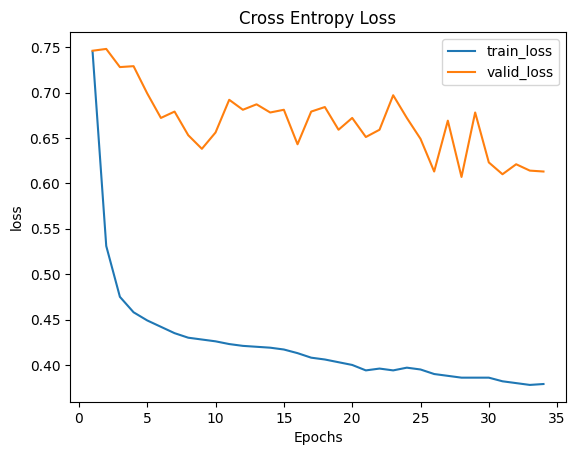

In [51]:
fig, ax= plt.subplots()

ax.plot(range(1,len(train_loss_list)+1), train_loss_list, label='train_loss')
ax.plot(range(1,len(valid_loss_list)+1), valid_loss_list, label='valid_loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('loss')
ax.set_title('Cross Entropy Loss')
ax.legend()

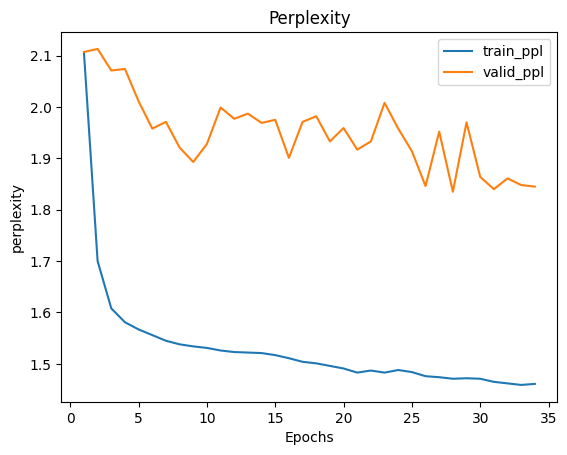

In [103]:
fig, ax= plt.subplots()

ax.plot(range(1,len(train_ppl_list)+1), train_ppl_list, label='train_ppl')
ax.plot(range(1,len(valid_ppl_list)+1), valid_ppl_list, label='valid_ppl')
ax.set_xlabel('Epochs')
ax.set_ylabel('perplexity')
ax.set_title('Perplexity')
ax.legend()

- Conjunto de prueba

In [ ]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch[0].to(device)
            trg = batch[1].to(device)
            # src = [batch size, L, N]
            # trg = [batch size, K]
            output = model(src, trg, 0)  # apaga teacher forcing
            # output = [batch size, K, label_size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [batch size * (K - 1), label_size]
            trg = trg[1:].view(-1)
            # trg = [batch size * (K - 1)]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [112]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from Levenshtein import distance as levenshtein_distance

def evaluate_test_metrics(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    all_preds = []
    all_targets = []
    levenshtein_distances = []

    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            src = batch[0].to(device)
            trg = batch[1].to(device)
            # src = [batch size, L, N]
            # trg = [batch size, K]

            output = model(src, trg, 0)  # apaga teacher forcing
            # output = [batch size, K, label_size]
            output_dim = output.shape[-1]
            all_output = output[1:].view(-1, output_dim)
            # output = [batch size * (K - 1), label_size]
            all_trg = trg[1:].view(-1)
            # trg = [batch size * (K - 1)]

            loss = criterion(all_output, all_trg)
            test_loss += loss.item()

            preds_plain = torch.argmax(all_output, dim=1).cpu().numpy()
            all_trg = all_trg.cpu().numpy()
            all_preds.extend(preds_plain)
            all_targets.extend(all_trg)

            # Calcular distancia de Levenshtein por secuencia
            preds = torch.argmax(output, dim=2)
            targets = trg
            for pred_seq, target_seq in zip(preds, targets):
                levenshtein_distances.append(levenshtein_distance(str(pred_seq), str(target_seq)))

    # Convertir listas a arrays de numpy
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calcular métricas
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)
    avg_levenshtein = np.mean(levenshtein_distances)

    # Calcular pérdida promedio
    avg_test_loss = test_loss / len(test_loader)

    # Matriz de confusión
    conf_matrix = confusion_matrix(all_targets, all_preds)
    print(classification_report(all_targets,all_preds))

    return avg_test_loss, accuracy, precision, recall, f1, conf_matrix, avg_levenshtein, levenshtein_distances


In [113]:
# Ejemplo de uso:
test_loss, test_accuracy, test_precision, test_recall, test_f1, conf_matrix, avg_levenshtein, LV_list = evaluate_test_metrics(
    model, test_loader, criterion, device
)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print(f"Test Recall: {test_recall:.3f}")
print(f"Test F1 Score: {test_f1:.3f}")
print(f"Average Levenshtein Distance: {avg_levenshtein:.3f}")


              precision    recall  f1-score   support

           0       1.00      0.05      0.09     21281
           1       1.00      0.05      0.09     19876
           2       0.75      1.00      0.86    116004

    accuracy                           0.75    157161
   macro avg       0.92      0.36      0.35    157161
weighted avg       0.81      0.75      0.66    157161

Test Loss: 0.653
Test Accuracy: 0.750
Test Precision: 0.814
Test Recall: 0.750
Test F1 Score: 0.655
Average Levenshtein Distance: 40.316


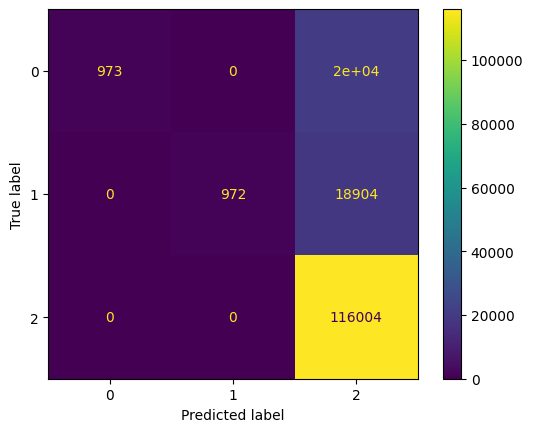

In [111]:
ConfusionMatrixDisplay(conf_matrix, display_labels=[0,1,2]).plot()

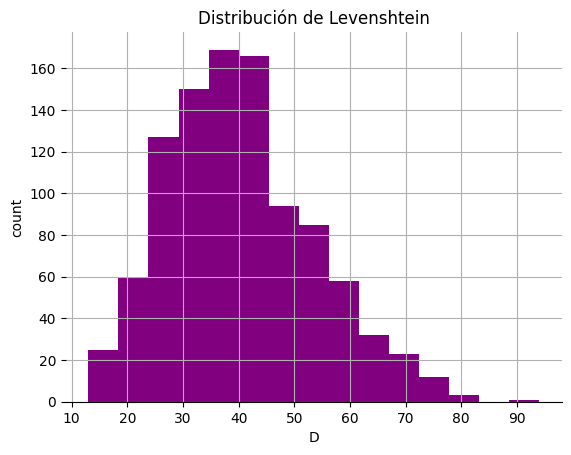

In [101]:
pd.Series(LV_list).hist(bins=15, color='purple')
plt.title('Distribución de Levenshtein')
plt.gca().set_xlabel('D')
plt.gca().set_ylabel('count')
plt.gca().spines[['right', 'top', 'left']].set_visible(False)

## Attention TEST

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super(Encoder, self).__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        return outputs, hidden, cell

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = torch.nn.LSTM(output_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell):
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell

In [ ]:
class Seq2SeqWithAttention(torch.nn.Module):
    def __init__(self, encoder, decoder, attention, hidden_dim):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = attention
        self.hidden_dim = hidden_dim

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = 3  # As there are 3 possible labels [0, 1, 2]

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(src.device)

        encoder_outputs, hidden, cell = self.encoder(src)

        input = trg[:, 0]

        for t in range(1, trg_len):
            context_vector, _ = self.attention(encoder_outputs, hidden[-1])
            input = input.unsqueeze(1)
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output
            teacher_force = np.random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1

        return outputs

In [ ]:
# Definición de parámetros
input_dim = 64
hidden_dim = 128
output_dim = 3  # Etiquetas [0, 1, 2]

encoder = Encoder(input_dim, hidden_dim)
attention = Attention(hidden_dim)
decoder = Decoder(output_dim, hidden_dim)
model = Seq2SeqWithAttention(encoder, decoder, attention, hidden_dim)
